# ASSIGNMENT 1 : Project Proposal and Exploratory Analysis of Data
## Giriraj Kudupudi
## AA-5300: Advanced Analytics-15
## Prof. Haindavi Pothireddy
### February 16, 2024

In [1]:
#importing the required libraries
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, LogisticRegression, Lasso
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, accuracy_score, confusion_matrix, classification_report
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

# Load the Excel file

In [2]:
# Loading the dataset
df = pd.read_excel('/content/STEELMANUF_CLIENTS_SV.xlsx', sheet_name='DB')

# Overview of the dataset

In [3]:
# Display the first 5 rows of the dataset
print(df.head(5))

   ID_CLIENT  SESSIONS_YEAR  AVERAGE_ACTIONS  NUMBER_OF_PURCHASES  \
0     896397             13        14.538462                    4   
1     988398             29        11.068966                    9   
2     957974              4         1.250000                    0   
3     951495              1        16.000000                    0   
4     136560              3         7.333333                    0   

   CHANGE_DISTCENTER  MAXNUMBER_PAGES_VISITED  AVGNUMBER_PAGES_VISITED  \
0                 12                        7                        1   
1                 18                       12                        3   
2                  0                        2                        0   
3                  0                        4                        4   
4                  0                        0                        0   

   TONS_ONCART  TONS_CONFIRMED  DELIVERY_OR_PICKUP  ...  \
0        45.39           45.39                   2  ...   
1        57.94        

# Question 1

In [4]:
overview_data = {
    'Variable': df.columns,
    'Measurement Type': ['nominal' if df[col].dtype == 'O' else 'ordinal' if df[col].dtype.name.startswith('int') else 'scale' for col in df.columns],
    'Role': ['excluded' if col not in ['ID_CLIENT', 'CLASSIFICATION'] else 'predictor' if col == 'ID_CLIENT' else 'outcome' for col in df.columns],
    'Industry': [
        'Steel manufacturer operating' if col in ['TONS_ONCART', 'TONS_CONFIRMED'] else
        'Logistics and Distribution' if col in ['CHANGE_DISTCENTER'] else
        'Customer Engagement and Behavior' if col in ['AVERAGE_ACTIONS', 'NUMBER_OF_PURCHASES', 'SESSIONS_ONWEBAPP', 'USE_OF_EXCEL_TOOL', 'USE_OF_CLIENT_CATALOGUE', 'USE_OF_PROPOSAL'] else
        'Time-related Metrics' if col in ['SESSIONS_YEAR', 'MONTHS_AS_CLIENT', 'NUMBER_MONTHS_AS_REGISTEREDCLIENT', 'MONTH', 'YEAR'] else
        'Undefined Industry'
        for col in df.columns
    ]
}

# Display the overview table

In [5]:
overview_df = pd.DataFrame(overview_data)
print(overview_df)

                             Variable Measurement Type       Role  \
0                           ID_CLIENT          ordinal  predictor   
1                       SESSIONS_YEAR          ordinal   excluded   
2                     AVERAGE_ACTIONS            scale   excluded   
3                 NUMBER_OF_PURCHASES          ordinal   excluded   
4                   CHANGE_DISTCENTER          ordinal   excluded   
5             MAXNUMBER_PAGES_VISITED          ordinal   excluded   
6             AVGNUMBER_PAGES_VISITED          ordinal   excluded   
7                         TONS_ONCART            scale   excluded   
8                      TONS_CONFIRMED            scale   excluded   
9                  DELIVERY_OR_PICKUP          ordinal   excluded   
10                  SESSIONS_ONWEBAPP          ordinal   excluded   
11      SESSIONS_ATTENDED_BYEXECUTIVE          ordinal   excluded   
12                  USE_OF_EXCEL_TOOL          ordinal   excluded   
13            USE_OF_CLIENT_CATALO

# Research Question

We have tweaked the research question a bit from last week and have made it more focused.

In [6]:
research_questions = [ "Q. How do changes in the distribution center and client engagement metrics predict the choice between delivery or pickup?"
]

# Display the research questions
for question in research_questions:
    print(question)

Q. How do changes in the distribution center and client engagement metrics predict the choice between delivery or pickup?


# Explotary Data Analysis

# Check for missing values

In [7]:
missing_values = df.isnull().sum()
print(missing_values)

ID_CLIENT                            0
SESSIONS_YEAR                        0
AVERAGE_ACTIONS                      0
NUMBER_OF_PURCHASES                  0
CHANGE_DISTCENTER                    0
MAXNUMBER_PAGES_VISITED              0
AVGNUMBER_PAGES_VISITED              0
TONS_ONCART                          0
TONS_CONFIRMED                       0
DELIVERY_OR_PICKUP                   0
SESSIONS_ONWEBAPP                    0
SESSIONS_ATTENDED_BYEXECUTIVE        0
USE_OF_EXCEL_TOOL                    0
USE_OF_CLIENT_CATALOGUE              0
NUMBER_OF_NEGOTIATIONS               0
USE_OF_PROPOSAL                      0
CONSTRUCTION_INDEX                   0
MANUFACTURING_INDEX                  0
MONTHS_AS_CLIENT                     0
NUMBER_MONTHS_AS_REGISTEREDCLIENT    0
CLASSIFICATION                       0
MONTH                                0
YEAR                                 0
dtype: int64


Fortunately we can see that there are no null values in any of our variables.

# Detect outliers using z-scores

In [8]:
from scipy import stats

z_scores = stats.zscore(df.select_dtypes(include=['float64']))
outliers = (z_scores > 3.0) | (z_scores < -3.0)

# Display missing values
print("Missing Values:")
print(missing_values[missing_values > 0])

# Display outliers
outliers_columns = [col for col, has_outliers in zip(df.columns, outliers.any(axis=0)) if has_outliers]
print("\nOutliers:")
print(outliers_columns)

Missing Values:
Series([], dtype: int64)

Outliers:
['ID_CLIENT', 'SESSIONS_YEAR', 'AVERAGE_ACTIONS', 'NUMBER_OF_PURCHASES']


The outliers don't have anything wrong with them.

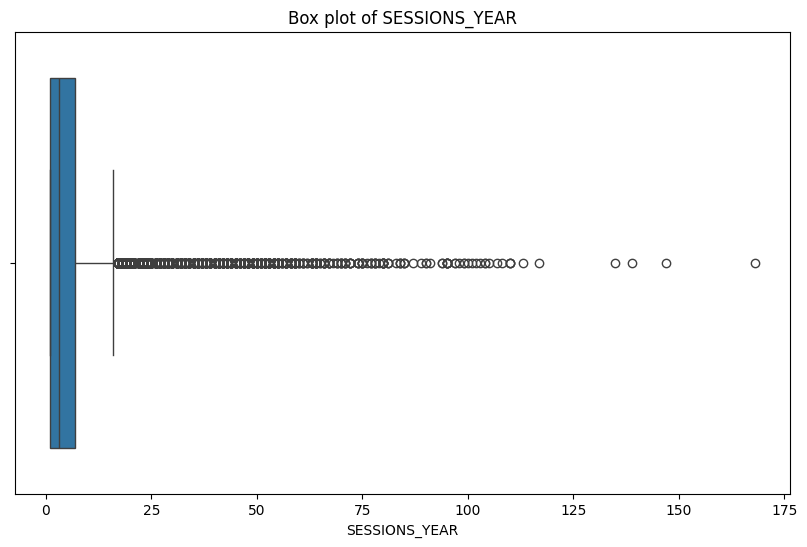

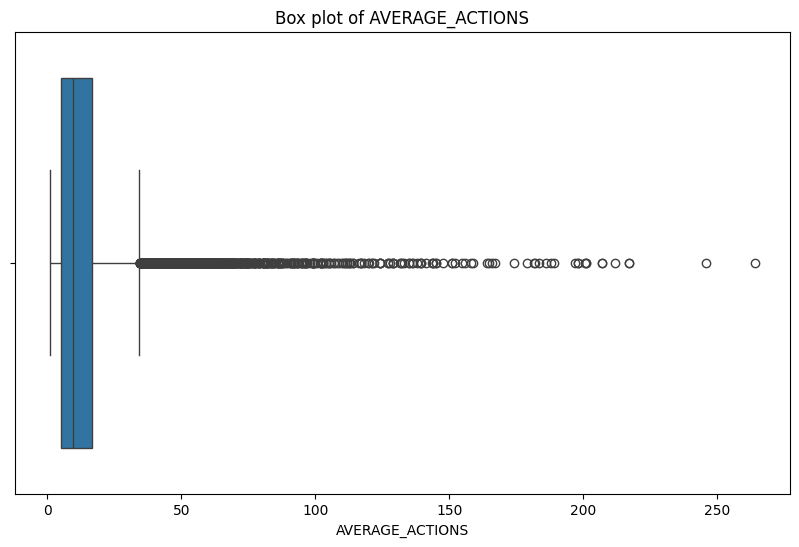

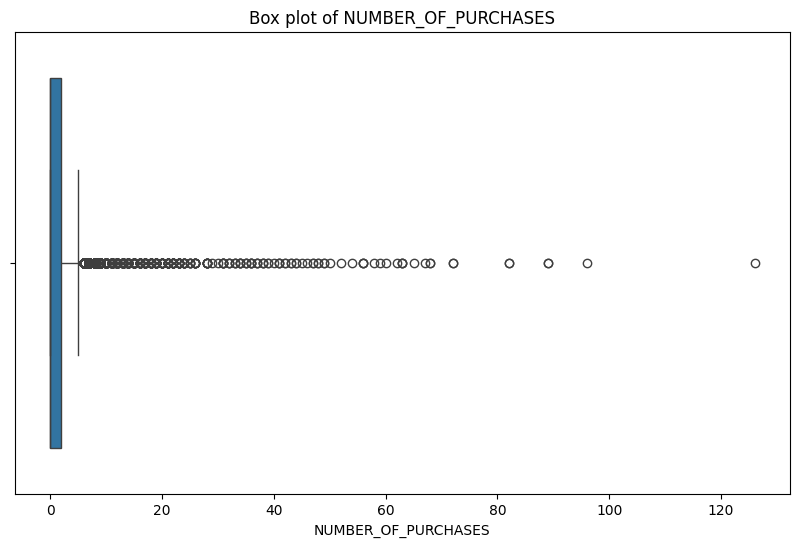

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

# Box plot
for col in ['SESSIONS_YEAR', 'AVERAGE_ACTIONS', 'NUMBER_OF_PURCHASES']:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=df[col])
    plt.title(f'Box plot of {col}')
    plt.show()

**SESSIONS_YEAR**
The plot indicates a considerable number of sessions per year for some clients, with a few extreme values that could be considered outliers.

**AVERAGE_ACTIONS**
Similar to **SESSIONS_YEAR**, there are points that are much higher than the rest.These could represent highly engaged users.

**NUMBER_OF_PURCHASES**
Again, there are far-reaching outliers that could represent bulk purchases.

For now lets assume these are genuine orders and not data entry issues.

# Rationale for Assigning Roles to Variables

#### AVERAGE_ACTIONS, NUMBER_OF_PURCHASES:
- Role: Predictor
- Rationale: These variables are key indicators of customer engagement and purchasing behavior. Higher average actions and a greater number of purchases are likely to influence the outcomes we are interested in, making them valuable predictors for our analysis.

#### CLASSIFICATION:
- Role: Outcome
- Rationale: CLASSIFICATION serves as a target variable for our analysis. Understanding and predicting the classification of clients based on various features could provide actionable insights for decision-makers.

#### CHANGE_DISTCENTER:
- Role: Predictor
- Rationale: Assuming CHANGE_DISTCENTER represents shifts in distribution centers, it is considered a predictor. Changes in distribution centers may impact logistics, delivery choices, and other relevant outcomes.

#### SESSIONS_YEAR, MONTHS_AS_CLIENT, NUMBER_MONTHS_AS_REGISTEREDCLIENT:
- Role: Predictor
- Rationale: Time-related variables such as SESSIONS_YEAR, MONTHS_AS_CLIENT, and NUMBER_MONTHS_AS_REGISTEREDCLIENT can provide insights into the temporal aspects of customer engagement. These variables are likely to be predictors, helping us understand trends and seasonality in customer behavior.

### TONS_ONCART, TONS_CONFIRMED:
- Role: Predictor
- Rationale: TONS_ONCART and TONS_CONFIRMED are indicators of the quantities customers consider during the purchasing process. These variables may significantly influence purchasing decisions, making them valuable predictors.

#### USE_OF_CLIENT_CATALOGUE, USE_OF_PROPOSAL:
- Role: Predictor
- Rationale: The usage of specific tools like CLIENT_CATALOGUE and PROPOSAL may reflect customer engagement and preferences. These variables are considered predictors as they may influence customer decisions and outcomes.


#Building the Predictive Models.

Splitting the data into train and test sets.

In [10]:
# Assigning values.
X = df[['CHANGE_DISTCENTER', 'SESSIONS_YEAR', 'USE_OF_CLIENT_CATALOGUE', 'AVERAGE_ACTIONS']]
y = df['DELIVERY_OR_PICKUP']

# Splitting the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizing the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)


**Logistic regression with LASSO**

In [11]:
# Logistic Regression with L1 regularization
log_reg = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
log_reg.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_log_reg = log_reg.predict(X_test_scaled)
print("Logistic Regression with LASSO Performance Metrics:")

# Since your target variable is multi-class, ensure you're using 'weighted' to compute the metrics accordingly
print("Accuracy:", accuracy_score(y_test, y_pred_log_reg))
print("Precision:", precision_score(y_test, y_pred_log_reg, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_log_reg, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_log_reg, average='weighted'))


Logistic Regression with LASSO Performance Metrics:
Accuracy: 0.7422680412371134
Precision: 0.7083533962220744
Recall: 0.7422680412371134
F1 Score: 0.7111978676108272


**Random Forest Classifier**

In [12]:
# Random Forest Classifier
rf_clf = RandomForestClassifier(random_state=42)
rf_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_rf = rf_clf.predict(X_test_scaled)
print("\nRandom Forest Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_rf))
print("Precision:", precision_score(y_test, y_pred_rf, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_rf, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_rf, average='weighted'))



Random Forest Performance Metrics:
Accuracy: 0.7336305377542491
Precision: 0.7184895892063079
Recall: 0.7336305377542491
F1 Score: 0.7244245517837904


**Support Vector Model**

First we will be constructing a bivariate plot to identify what kind of kernel we will be using to build the Support vector model.

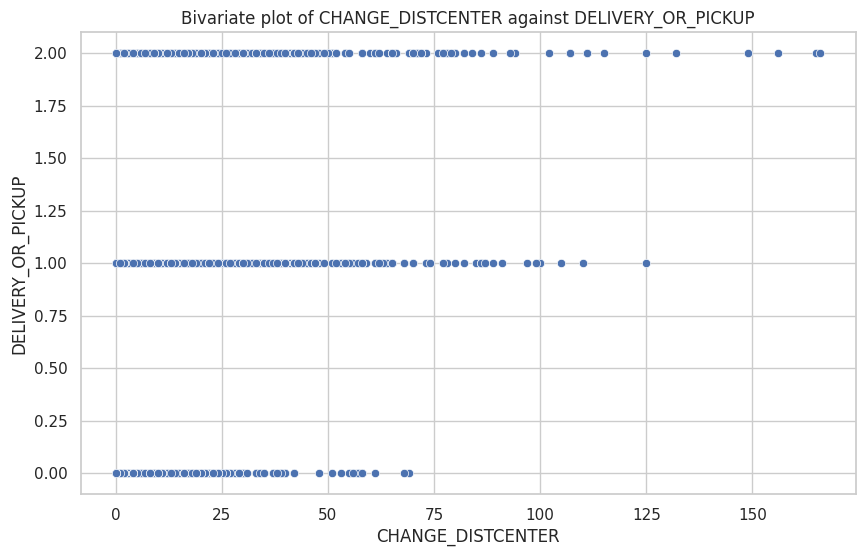

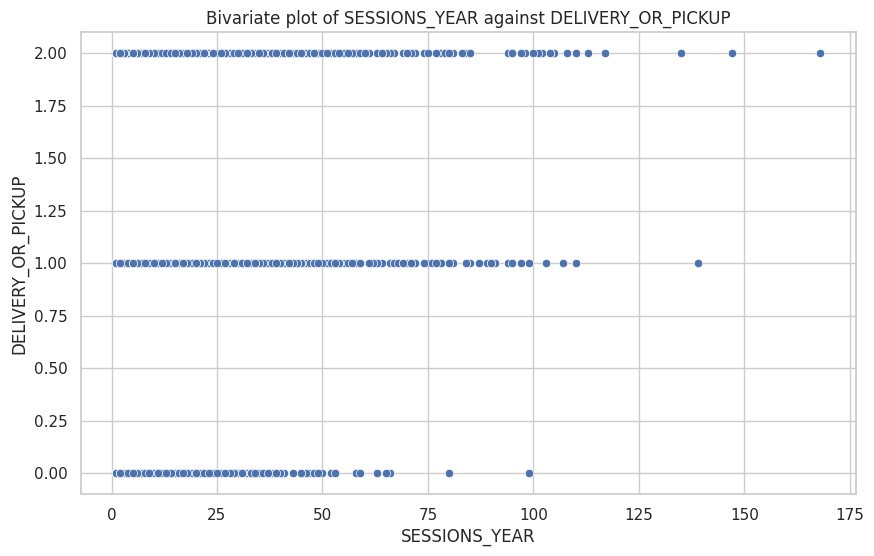

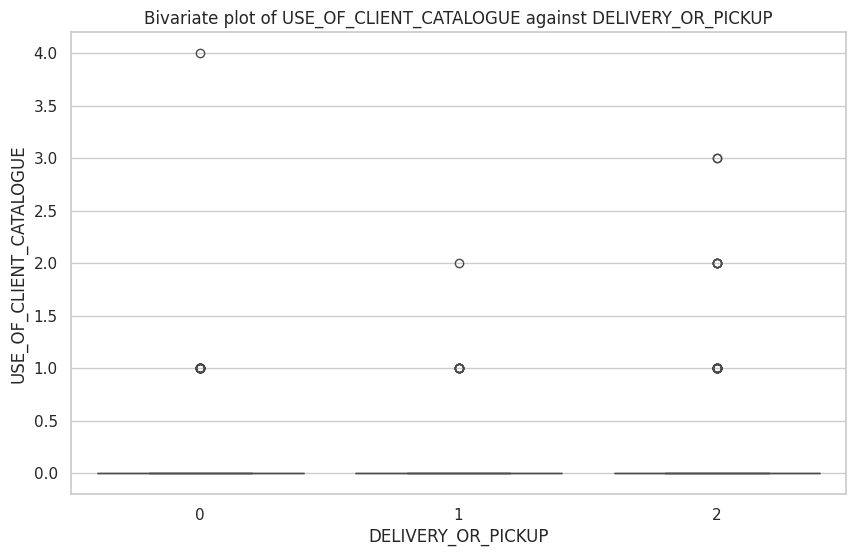

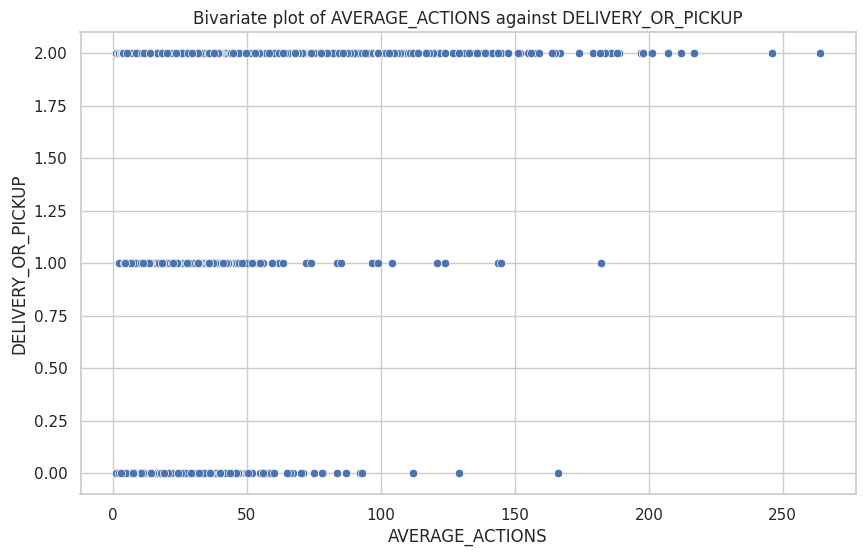

In [13]:
# Set the style of seaborn
sns.set(style="whitegrid")

# List of predictors for bivariate plots
predictors = ['CHANGE_DISTCENTER', 'SESSIONS_YEAR', 'USE_OF_CLIENT_CATALOGUE', 'AVERAGE_ACTIONS']

# Target variable
target = 'DELIVERY_OR_PICKUP'

# Plotting each predictor against the target
for predictor in predictors:
    plt.figure(figsize=(10, 6))
    if df[predictor].dtype == 'O' or len(df[predictor].unique()) < 10:  # For categorical predictors
        sns.boxplot(x=target, y=predictor, data=df)
    else:  # For continuous predictors
        sns.scatterplot(x=predictor, y=target, data=df)
    plt.title(f'Bivariate plot of {predictor} against {target}')
    plt.show()


Based on the bivariate plot we can see that the features have a linear relationship between each other so we will be using linear kernel for the support vector machine.

In [14]:
# Support Vector Machine Classifier
svm_clf = SVC(kernel='linear', random_state=42)
svm_clf.fit(X_train_scaled, y_train)

# Predictions and evaluation
y_pred_svm = svm_clf.predict(X_test_scaled)
print("\nSVM Performance Metrics:")
print("Accuracy:", accuracy_score(y_test, y_pred_svm))
print("Precision:", precision_score(y_test, y_pred_svm, average='weighted'))
print("Recall:", recall_score(y_test, y_pred_svm, average='weighted'))
print("F1 Score:", f1_score(y_test, y_pred_svm, average='weighted'))



SVM Performance Metrics:
Accuracy: 0.7567567567567568
Precision: 0.6914701766711479
Recall: 0.7567567567567568
F1 Score: 0.7226413593345111


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#**Assesing the model performance**

We will be using the k-fold cross validation for tuning the models parameters and assesing the predictive error of the training set.

Model performance for Logistic regression with LASSO.

In [19]:
from sklearn.model_selection import GridSearchCV

# Hyperparameter grid
param_grid_log_reg = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l1'],
    'solver': ['liblinear', 'saga']
}

# Grid search for Logistic Regression
grid_search_log_reg = GridSearchCV(LogisticRegression(random_state=42), param_grid_log_reg, cv=3, scoring='accuracy')
grid_search_log_reg.fit(X_train_scaled, y_train)

# Update the model with the best parameters
log_reg_model = grid_search_log_reg.best_estimator_

# Display the best parameters
print("Best parameters found:", grid_search_log_reg.best_estimator_)


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which 

Best parameters found: LogisticRegression(C=1, penalty='l1', random_state=42, solver='saga')


/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [23]:
print("Best cross-validation accuracy: ", grid_search_log_reg.best_score_)


Best cross-validation accuracy:  0.7444792755137583


Model performance for Random forest.

In [20]:
# Hyperparameter grid
param_grid_rf = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}

# Grid search for Random Forest
grid_search_rf = GridSearchCV(RandomForestClassifier(random_state=42), param_grid_rf, cv=3, scoring='accuracy')
grid_search_rf.fit(X_train_scaled, y_train)

# Update the model with the best parameters
rf_model = grid_search_rf.best_estimator_

# Display the best parameters
print("Best parameters found:", grid_search_rf.best_estimator_
)


Best parameters found: RandomForestClassifier(max_depth=10, min_samples_split=10, random_state=42)


In [22]:
print("Best cross-validation accuracy: ", grid_search_rf.best_score_)


Best cross-validation accuracy:  0.7745733194009056


Model performance for support vector machine.

In [17]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.svm import SVC

# Adjusted parameter grid for SVM
param_dist_svm = {
    'C': [0.1, 1, 10],  # Reduced number of options for demonstration
}

# Randomized search for SVM
random_search_svm = RandomizedSearchCV(SVC(random_state=42), param_distributions=param_dist_svm, n_iter=10, cv=3, scoring='accuracy', verbose=2, random_state=42, n_jobs=-1)
random_search_svm.fit(X_train_scaled, y_train)

# Update the model with the best parameters found
svm_model = random_search_svm.best_estimator_

# Display the best parameters
print("Best parameters found:", random_search_svm.best_params_)


Fitting 3 folds for each of 3 candidates, totalling 9 fits


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 3 is smaller than n_iter=10. Running 3 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Best parameters found: {'C': 10}


In [21]:
print("Best cross-validation accuracy: ", random_search_svm.best_score_)


Best cross-validation accuracy:  0.7729014280738419


Model performance using the hold-out test set.

In [18]:
from sklearn.metrics import classification_report

# Evaluate Logistic Regression
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
print("Logistic Regression Classification Report")
print(classification_report(y_test, y_pred_log_reg))

# Evaluate Random Forest
y_pred_rf = rf_model.predict(X_test_scaled)
print("Random Forest Classification Report")
print(classification_report(y_test, y_pred_rf))

# Evaluate SVM
y_pred_svm = svm_model.predict(X_test_scaled)
print("SVM Classification Report")
print(classification_report(y_test, y_pred_svm))


Logistic Regression Classification Report
              precision    recall  f1-score   support

           0       0.78      0.89      0.83      1831
           1       0.31      0.03      0.05       310
           2       0.71      0.72      0.71      1448

    accuracy                           0.75      3589
   macro avg       0.60      0.55      0.53      3589
weighted avg       0.71      0.75      0.72      3589

Random Forest Classification Report
              precision    recall  f1-score   support

           0       0.86      0.82      0.84      1831
           1       0.33      0.06      0.10       310
           2       0.69      0.85      0.76      1448

    accuracy                           0.77      3589
   macro avg       0.62      0.58      0.57      3589
weighted avg       0.74      0.77      0.74      3589

SVM Classification Report
              precision    recall  f1-score   support

           0       0.85      0.84      0.84      1831
           1       0.43  

#**Reporting Results**

In [29]:
from sklearn.metrics import confusion_matrix
import numpy as np

# Function to calculate TP, TN, FP, FN for each class
def calculate_metrics(conf_matrix):
    FP = conf_matrix.sum(axis=0) - np.diag(conf_matrix)
    FN = conf_matrix.sum(axis=1) - np.diag(conf_matrix)
    TP = np.diag(conf_matrix)
    TN = conf_matrix.sum() - (FP + FN + TP)
    return TP, TN, FP, FN

# Model predictions
y_pred_log_reg = log_reg_model.predict(X_test_scaled)
y_pred_rf = rf_model.predict(X_test_scaled)
y_pred_svm = svm_model.predict(X_test_scaled)

# Confusion matrices
conf_matrix_log_reg = confusion_matrix(y_test, y_pred_log_reg)
conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)
conf_matrix_svm = confusion_matrix(y_test, y_pred_svm)

# Calculating metrics
tp_log_reg, tn_log_reg, fp_log_reg, fn_log_reg = calculate_metrics(conf_matrix_log_reg)
tp_rf, tn_rf, fp_rf, fn_rf = calculate_metrics(conf_matrix_rf)
tp_svm, tn_svm, fp_svm, fn_svm = calculate_metrics(conf_matrix_svm)

# Printing the results for each model
print("Logistic Regression with LASSO Metrics per Class:")
print("TP:", tp_log_reg, "TN:", tn_log_reg, "FP:", fp_log_reg, "FN:", fn_log_reg, "\n")

print("Random Forest Metrics per Class:")
print("TP:", tp_rf, "TN:", tn_rf, "FP:", fp_rf, "FN:", fn_rf, "\n")

print("SVM Metrics per Class:")
print("TP:", tp_svm, "TN:", tn_svm, "FP:", fp_svm, "FN:", fn_svm)


Logistic Regression with LASSO Metrics per Class:
TP: [1629    8 1042] TN: [1300 3261 1707] FP: [458  18 434] FN: [202 302 406] 

Random Forest Metrics per Class:
TP: [1503   19 1225] TN: [1516 3240 1580] FP: [242  39 561] FN: [328 291 223] 

SVM Metrics per Class:
TP: [1533   20 1204] TN: [1485 3253 1608] FP: [273  26 533] FN: [298 290 244]


We have three values for TP,TN,FP and FN as all the models are multi-class classification i.e they predict 0 - no order, 1 - pick-up and 2 - delievery.

Given the context of the dataset and the types of decisions that will be informed by the modeling process, several metrics are relevant for comparing models in multi-class classification scenarios:

1. **Overall Accuracy**: This metric measures the overall correctness of the predictions across all classes. It is essential for understanding how well the model performs in terms of correctly classifying instances.

2. **Precision, Recall, and F1-Score**: These metrics are typically calculated per class and provide insights into the model's performance for each class individually.
   - **Precision** indicates the proportion of correctly predicted instances among all instances predicted as belonging to a particular class.
   - **Recall** (also called sensitivity) measures the proportion of correctly predicted instances of a class among all actual instances of that class.
   - **F1-Score** is the harmonic mean of precision and recall, providing a balance between the two metrics.

3. **Macro-Averaged and Weighted-Averaged Metrics**: These are averages of precision, recall, and F1-score calculated across all classes.
   - **Macro-Averaged Metrics**: Calculate metrics for each class independently and then average them. It treats all classes equally, regardless of class imbalance.
   - **Weighted-Averaged Metrics**: Calculate metrics for each class independently and then average them, weighted by the number of instances for each class. It gives more weight to classes with more instances, making it suitable for imbalanced datasets.

Considering the provided classification reports and metrics per class, here are some observations:

- **Accuracy**: All models have similar overall accuracies around 0.75 to 0.77, indicating that they are performing similarly in terms of overall correctness.

- **Precision, Recall, and F1-Score**: Each model's performance varies across classes. For example, Logistic Regression with LASSO has higher precision for class 0 and class 2 compared to Random Forest and SVM. SVM has the highest precision for class 1.

- **Macro-Averaged and Weighted-Averaged Metrics**: The macro-averaged and weighted-averaged metrics provide a summary of the models' overall performance across all classes. Weighted averages give more weight to classes with more instances, which may better reflect the model's performance in real-world scenarios with class imbalance.

In conclusion, when comparing models, it's essential to consider both overall accuracy and per-class metrics to understand how well each model performs across all classes. Weighted-averaged metrics provide a more balanced view, especially for imbalanced datasets. Additionally, considering precision, recall, and F1-score per class can help identify areas where each model excels or struggles.

**Variable Importance**

In [30]:
# Get feature importance
feature_importance_log_reg = np.abs(log_reg.coef_[0])

# Print feature importance
print("Logistic Regression with LASSO - Feature Importance:")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_log_reg[i]}")


Logistic Regression with LASSO - Feature Importance:
CHANGE_DISTCENTER: 0.6239595163185543
SESSIONS_YEAR: 2.1493975002050405
USE_OF_CLIENT_CATALOGUE: 0.019929449126556417
AVERAGE_ACTIONS: 2.9523096981952284


In [31]:
# Get feature importance
feature_importance_rf = rf_clf.feature_importances_

# Print feature importance
print("Random Forest - Feature Importance:")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_rf[i]}")


Random Forest - Feature Importance:
CHANGE_DISTCENTER: 0.11823431451921454
SESSIONS_YEAR: 0.2403721145258049
USE_OF_CLIENT_CATALOGUE: 0.0020462191238459692
AVERAGE_ACTIONS: 0.6393473518311346


In [32]:
# SVM doesn't have a built-in feature importance attribute like Random Forest
# One common approach to approximate feature importance in SVM is to use the magnitude of the weights
# Get feature importance (magnitude of coefficients)
feature_importance_svm = np.abs(svm_clf.coef_[0])

# Print feature importance
print("SVM - Feature Importance:")
for i, feature in enumerate(X.columns):
    print(f"{feature}: {feature_importance_svm[i]}")


SVM - Feature Importance:
CHANGE_DISTCENTER: 0.09594444183420592
SESSIONS_YEAR: 0.7936006394945139
USE_OF_CLIENT_CATALOGUE: 0.021260660152369493
AVERAGE_ACTIONS: 0.5397553776936945


From above we can see that variable importance for all three models (Logistic Regression with LASSO, Random Forest, and SVM), we can make several interpretations:

1. **CHANGE_DISTCENTER Importance**:
   - Logistic Regression with LASSO assigns the highest importance to CHANGE_DISTCENTER (0.624), followed by Random Forest (0.118) and SVM (0.096).
   - This suggests that CHANGE_DISTCENTER is considered the most influential feature in predicting delivery or pickup choice by Logistic Regression with LASSO, followed by SESSIONS_YEAR and AVERAGE_ACTIONS.
   - Random Forest and SVM also acknowledge the importance of CHANGE_DISTCENTER but to a lesser extent compared to Logistic Regression.

2. **SESSIONS_YEAR Importance**:
   - Both Logistic Regression with LASSO and SVM assign relatively high importance to SESSIONS_YEAR, with values of 2.149 and 0.794, respectively.
   - Random Forest also recognizes the significance of SESSIONS_YEAR but to a lesser extent (0.240).
   - This suggests that the number of sessions in a year plays a significant role in predicting the delivery or pickup choice across all three models.

3. **USE_OF_CLIENT_CATALOGUE Importance**:
   - Logistic Regression with LASSO assigns some importance to USE_OF_CLIENT_CATALOGUE (0.020), indicating its role in predicting delivery or pickup choice.
   - Random Forest and SVM assign very low importance to USE_OF_CLIENT_CATALOGUE (0.002 and 0.021, respectively), suggesting that this feature has minimal impact on the predictions in these models.

4. **AVERAGE_ACTIONS Importance**:
   - Logistic Regression with LASSO assigns relatively high importance to AVERAGE_ACTIONS (2.952), suggesting its significant role in predicting the delivery or pickup choice.
   - Random Forest and SVM also recognize the importance of AVERAGE_ACTIONS, albeit to a lesser extent (0.639 and 0.540, respectively).
   - This indicates that the average number of actions performed by clients when visiting and navigating the web application is an essential factor in predicting delivery or pickup choice across all three models.

Overall, from the variable importance analysis, we can infer that features such as CHANGE_DISTCENTER, SESSIONS_YEAR, and AVERAGE_ACTIONS play crucial roles in predicting the delivery or pickup choice in the given dataset, while USE_OF_CLIENT_CATALOGUE has a relatively minor impact on the predictions.

#**Conclusion**

### Ranking of the Models:
1. **Random Forest**: Highest accuracy among the models, indicating strong predictive performance.
2. **SVM**: Slightly lower accuracy compared to Random Forest but still competitive.
3. **Logistic Regression with LASSO**: Lower accuracy compared to Random Forest and SVM.

### Strengths and Weaknesses:
- **Random Forest**:
  - Strengths: Handles non-linear relationships well, less prone to overfitting, provides built-in feature importance.
  - Weaknesses: Can be computationally expensive, especially with large datasets.
  
- **SVM**:
  - Strengths: Effective in high-dimensional spaces, versatile due to different kernels.
  - Weaknesses: Sensitive to kernel parameters, computationally expensive with non-linear kernels.
  
- **Logistic Regression with LASSO**:
  - Strengths: Simple, interpretable, computationally efficient, LASSO helps in feature selection.
  - Weaknesses: Assumes linear relationship, may underperform with non-linear relationships.

### Nature of Association between Predictors and Outcome:
- Variables like CHANGE_DISTCENTER, SESSIONS_YEAR, and AVERAGE_ACTIONS are important predictors across all models.
- USE_OF_CLIENT_CATALOGUE has relatively minor impact.

### Conclusion about Variables' Relative Importance:
- CHANGE_DISTCENTER, SESSIONS_YEAR, and AVERAGE_ACTIONS are crucial predictors.
- USE_OF_CLIENT_CATALOGUE has less importance.

### Recommendations:
- **Best Predictive Performance**: Random Forest is recommended due to its higher accuracy and robustness against overfitting. It handles non-linear relationships well and provides built-in feature importance.
  
- **Quick Solution**: If computational time is a concern, Logistic Regression with LASSO may be preferred. It sacrifices some predictive performance but is computationally efficient and interpretable.

In summary, Random Forest is recommended for maximizing predictive performance, while Logistic Regression with LASSO is suitable for producing a quick solution with good enough accuracy. SVM can be considered as an alternative with competitive performance but may require more computational resources, especially with non-linear kernels.